In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def AddNoise(img, mean=0, std=10):
    noise_factor = 1
    return img + noise_factor * np.random.normal(loc=mean, scale=std, size=img.shape)

def I_x(im, i, j):
    return -im[i-1,j-1] + im[i-1,j+1] - 2*im[i,j-1] + 2*im[i,j+1] - im[i+1,j-1] + im[i+1,j+1]

def I_y(im, i, j):
    return im[i-1,j-1] + im[i-1,j+1] - 2*im[i+1,j] + 2*im[i-1,j] - im[i+1,j-1] - im[i+1,j+1]

def Sobel(img):
    
    X = np.zeros((img.shape[0]+2, img.shape[1]+2))
    Y = np.zeros((img.shape[0]+2, img.shape[1]+2))
    
    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
            X[i-1,j-1] = I_x(img,i,j)
            
    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
            Y[i-1,j-1] = I_y(img,i,j)
    
    return X, Y

def Magnitude(X, Y):
    return (X*X + Y*Y)**(1/2)

def normalize255(img):
    M = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            M[i,j] = ((img[i,j] - img.min())/(img.max() - img.min()))*255
    return M

def Get_B(a):
    k = 0
    I = 0
    for i in range(a.shape[0]):
        k += a[i]
        if k/a.sum() >= 0.5:
            I = i+1
            break
    return I

def g(x,B):
    return np.exp(-(x/B)**2)

def pixel_com(im, i, j, B, l=0.1):
    DN = im[i-1,j] - im[i,j]
    DS = im[i+1,j] - im[i,j]
    DE = im[i,j+1] - im[i,j]
    DW = im[i,j-1] - im[i,j] 

    cN = g(DN, B)
    cS = g(DS, B)
    cE = g(DE, B)
    cW = g(DW, B)

    return im[i,j] + l*(cN*DN + cS*DS + cE*DE + cW*DW)

ListOfImage = []
def AnisotropicDiffusion(image, B, itr=1):
    
    A = np.zeros((image.shape[0]+2, image.shape[1]+2))

    for i in range(1,A.shape[0]-1):
        for j in range(1,A.shape[1]-1):
            A[i,j] = image[i-1,j-1]

    A2 = np.zeros(image.shape)

    for i in range(1,A.shape[0]-1):
        for j in range(1,A.shape[1]-1):
            A2[i-1,j-1] = pixel_com(A, i, j, B, l=0.2)
            
    ListOfImage.append(A2)
    
    if itr>1:
        for i in range(itr-1):
            A2 = AnisotropicDiffusion(A2, B)

    return A2

Text(0.5, 1.0, 'Noisy Image')

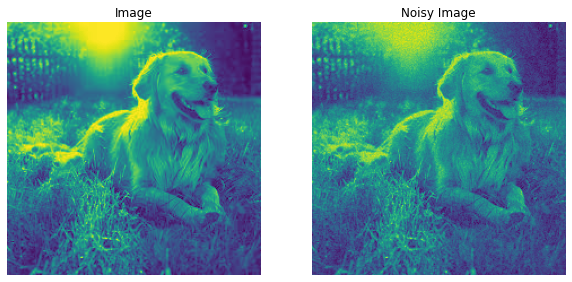

In [3]:
img = cv2.imread('E:\Dataset\dog.jpg', cv2.IMREAD_GRAYSCALE)
img_noisy = AddNoise(img, std=10)

fig = plt.figure(figsize=(10, 9))
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Image")

fig.add_subplot(rows, columns, 2)
plt.imshow(img_noisy)
plt.axis('off')
plt.title("Noisy Image")

In [4]:
P, Q = Sobel(img_noisy)

M_0 = Magnitude(P, Q)
M = np.zeros(img_noisy.shape)
for i in range(1,img_noisy.shape[0]-1):
    for j in range(1,img_noisy.shape[1]-1):
        M[i-1,j-1] = M_0[i,j]

M = normalize255(M)

Text(0.5, 1.0, 'Normalize Magnitude')

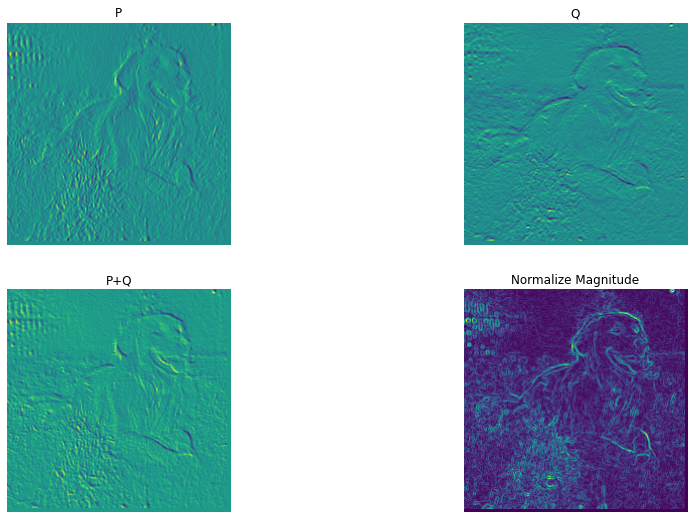

In [5]:
fig = plt.figure(figsize=(15, 9))
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(P)
plt.axis('off')
plt.title("P")

fig.add_subplot(rows, columns, 2)
plt.imshow(Q)
plt.axis('off')
plt.title("Q")

fig.add_subplot(rows, columns, 3)
plt.imshow(P+Q)
plt.axis('off')
plt.title("P+Q")

fig.add_subplot(rows, columns, 4)
plt.imshow(M)
plt.axis('off')
plt.title("Normalize Magnitude")

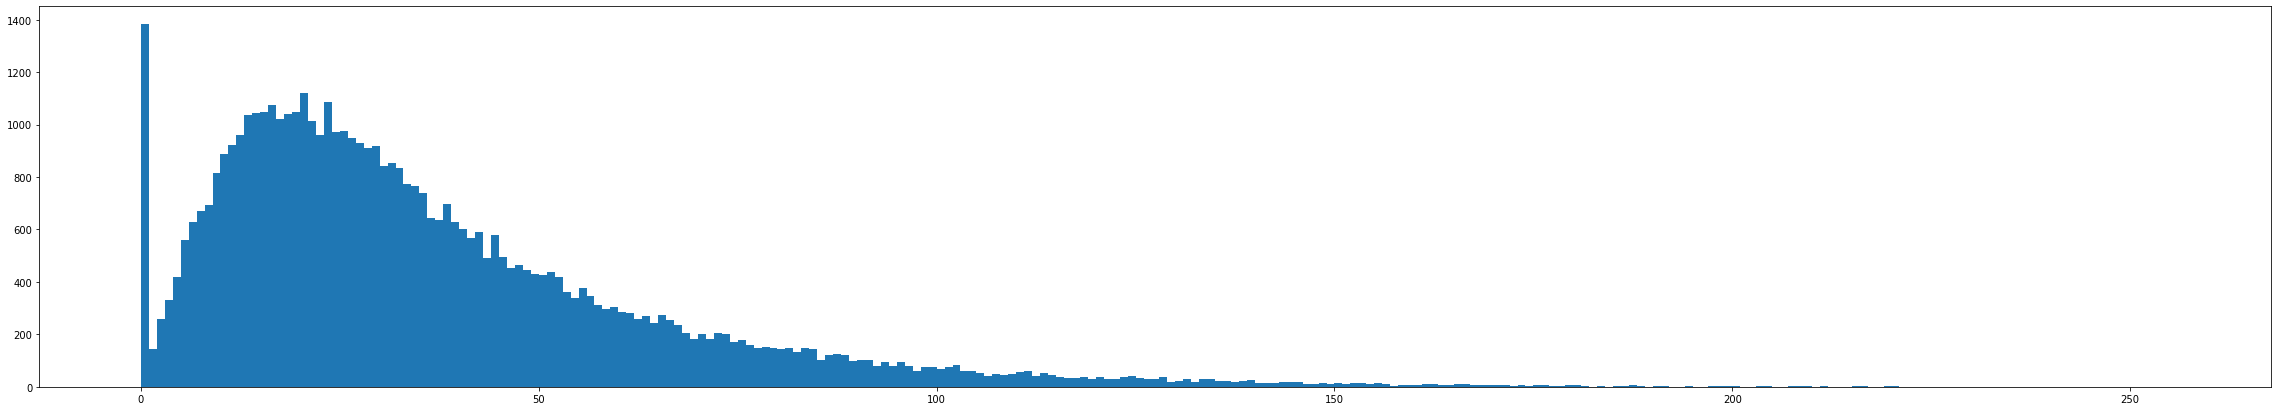

In [6]:
fig, ax = plt.subplots(figsize =(40, 7))
hist_fq, hist_range, _ = ax.hist(M.reshape(img_noisy.shape[0]*img_noisy.shape[1]), bins = [i for i in range(1+int(M.max()))])

In [7]:
hist_fq.shape

(255,)

In [8]:
B = Get_B(hist_fq)
B

30

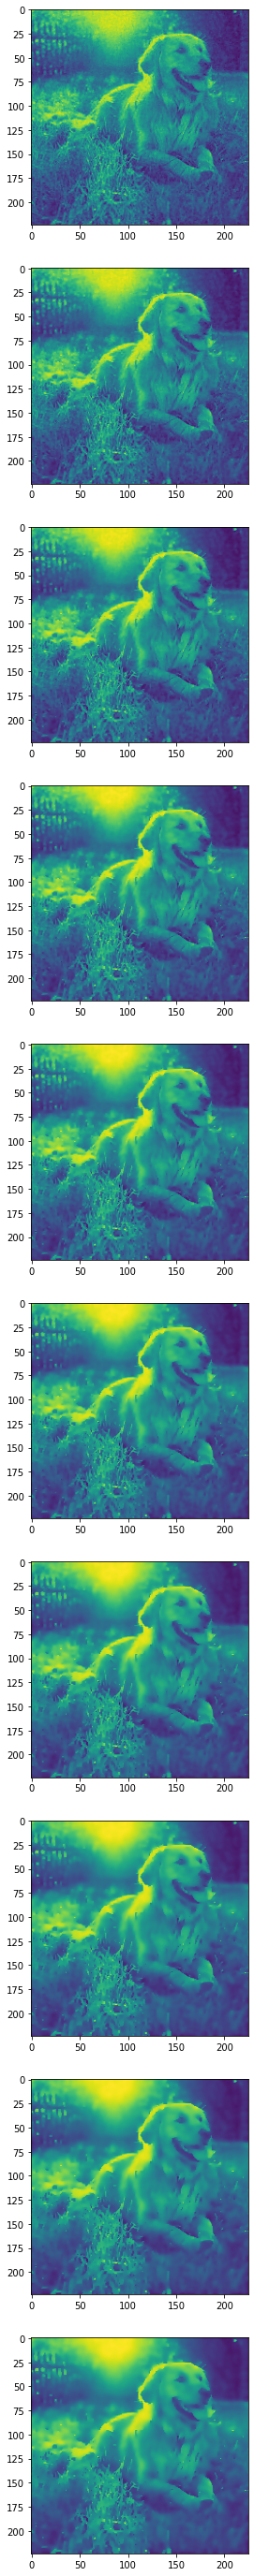

In [9]:
As = AnisotropicDiffusion(img_noisy, B, 10)

f, ax = plt.subplots(len(ListOfImage), figsize =(50,50))
for i in range(len(ListOfImage)):
    ax[i].imshow(ListOfImage[i])